<a href="https://colab.research.google.com/github/schwarer2006/KreditKartenFraudDetection/blob/main/KreditKartenAnomalieDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
pip install statsmodels


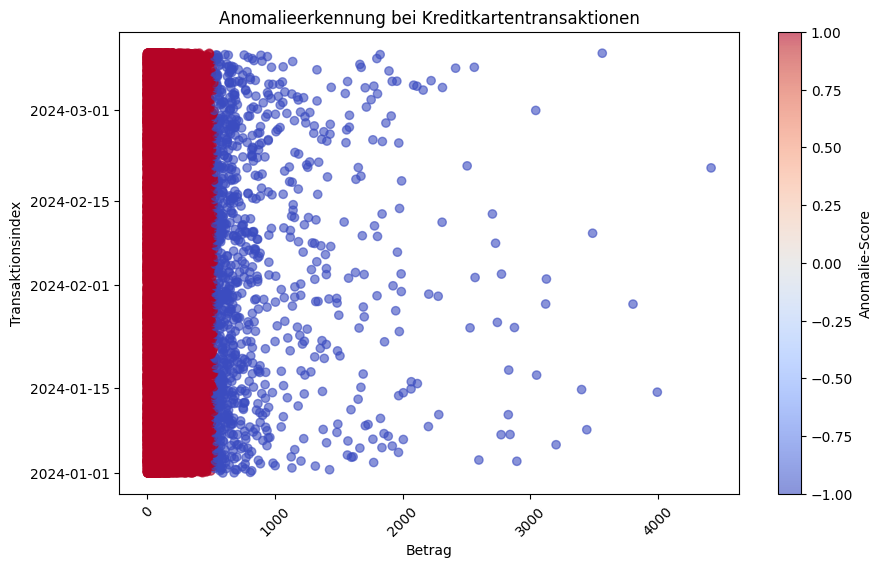

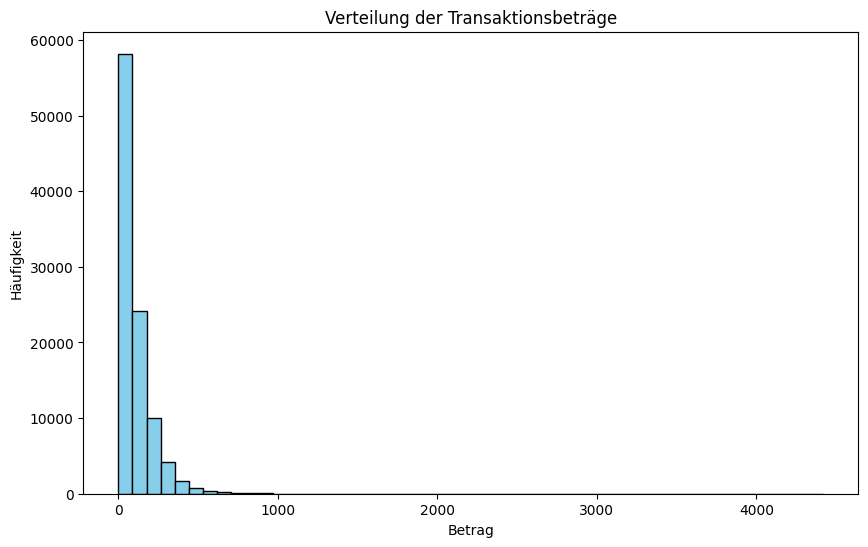

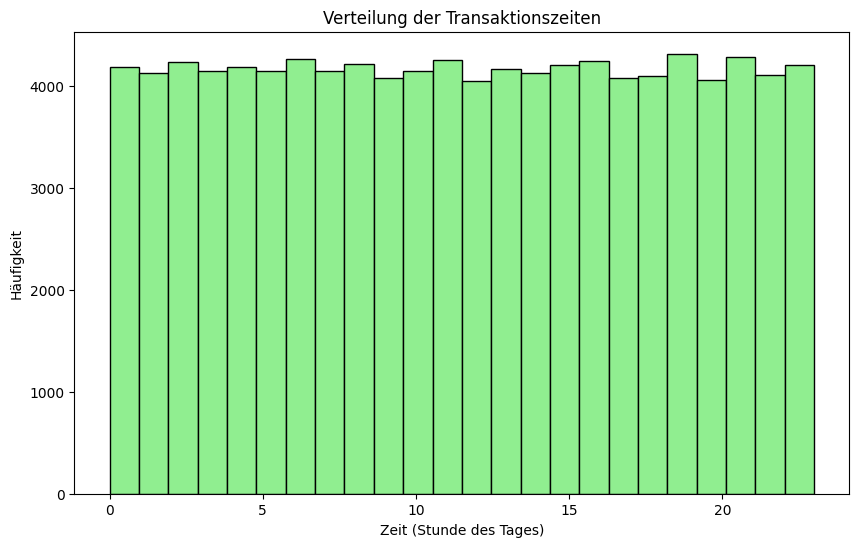

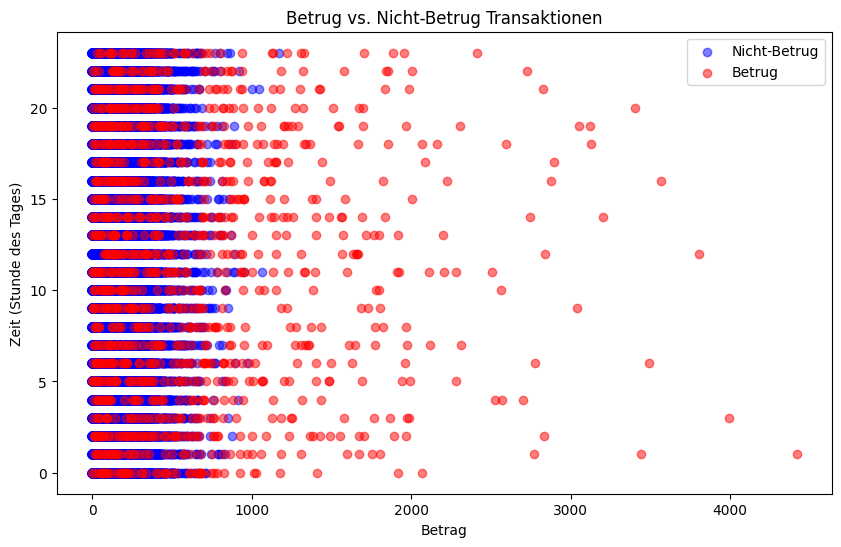

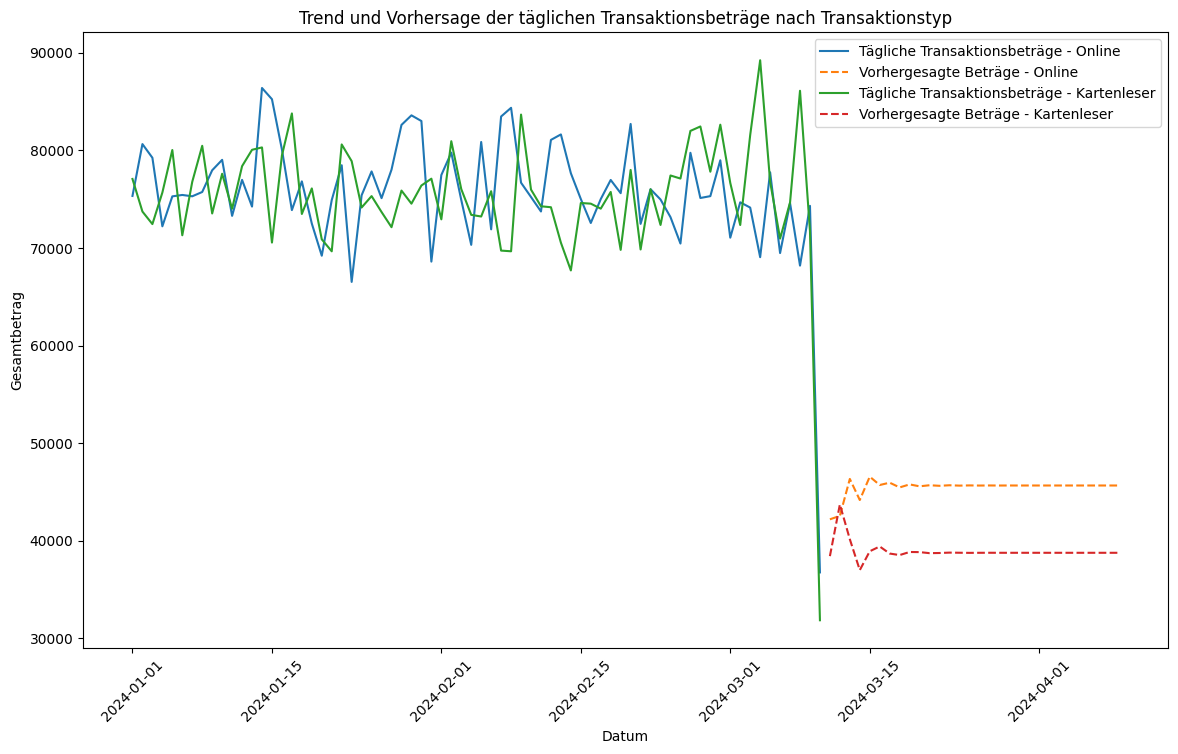

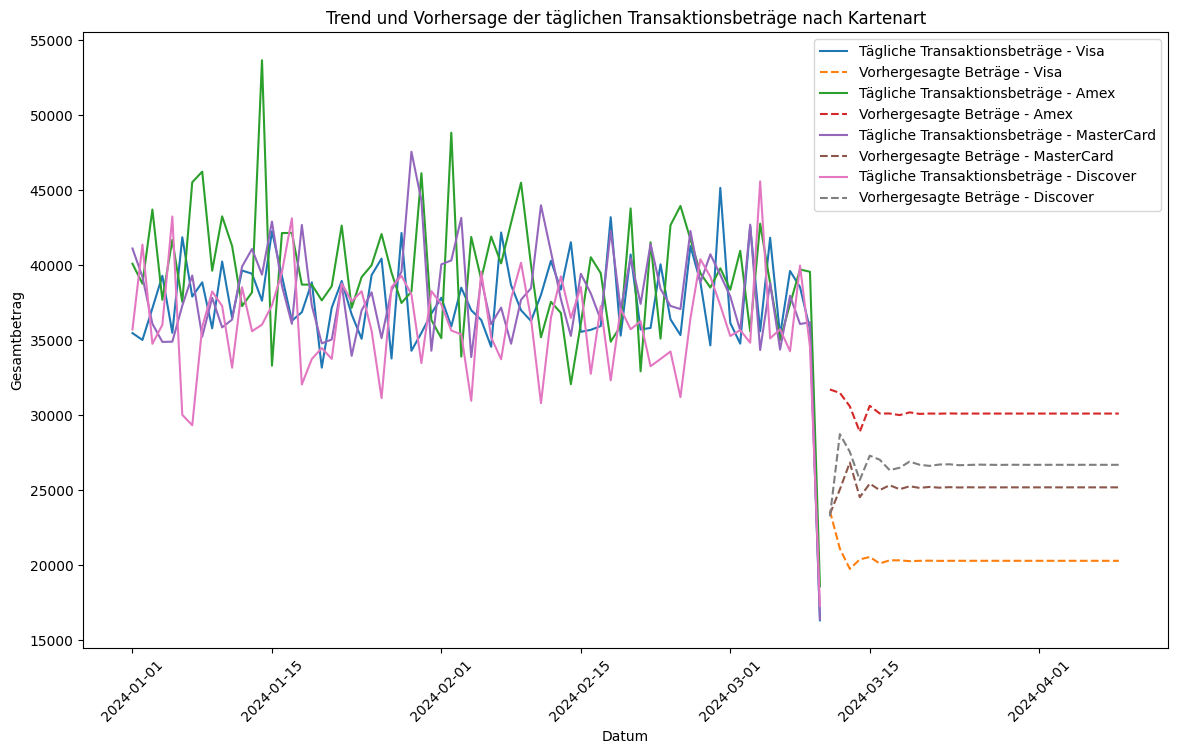

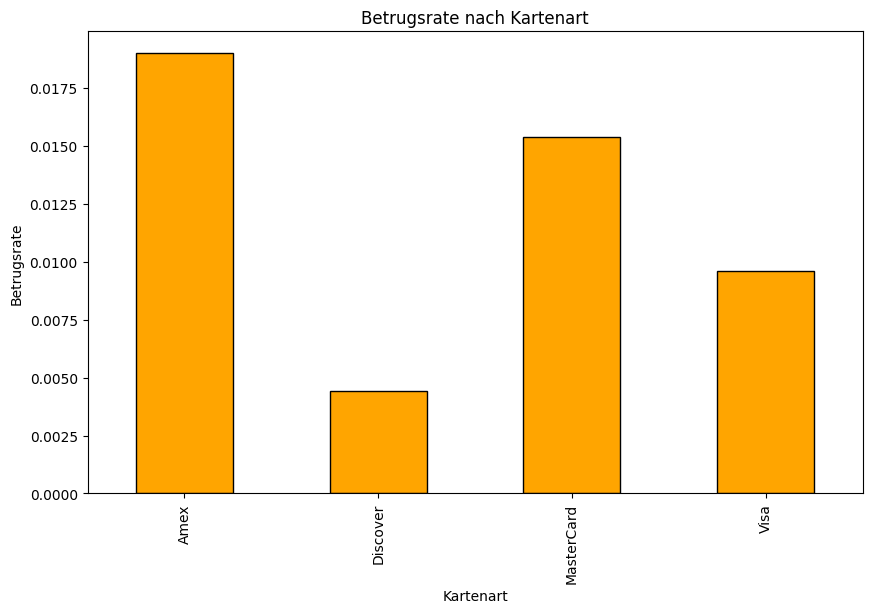

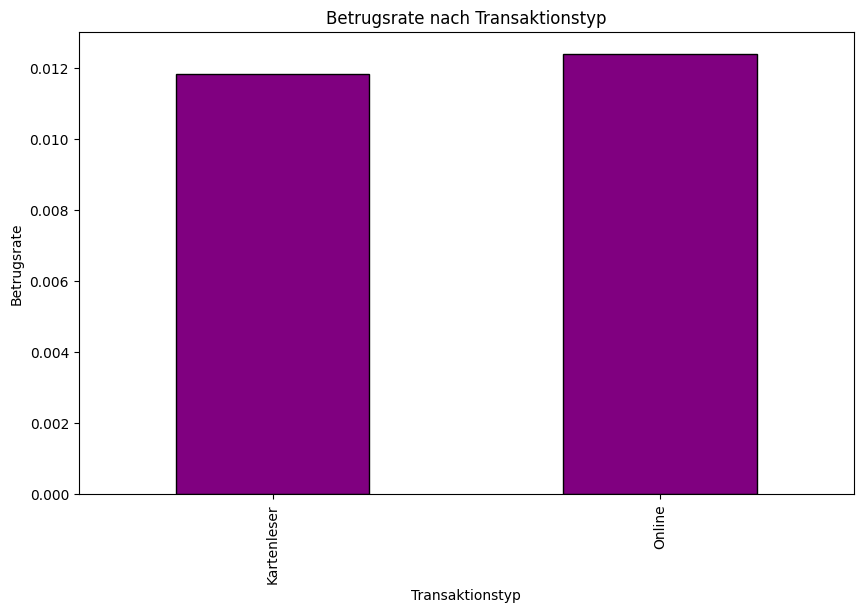

Betrugsfälle:
       TransactionID       Amount   Time  CustomerID    CardType  \
3                  3   590.559969  13:09        1011  MasterCard   
38                38   679.563904  00:43        1131  MasterCard   
146              146   806.065802  22:08        1677        Amex   
531              531   817.244560  07:13        1560        Amex   
532              532   569.487340  17:18        1906        Amex   
...              ...          ...    ...         ...         ...   
99512          99512   758.247753  04:42        1522        Visa   
99540          99540   538.078252  13:46        1595    Discover   
99614          99614   607.766417  15:49        1879    Discover   
99617          99617  1823.548526  08:43        1065        Amex   
99949          99949  3564.365881  16:50        1015        Amex   

      TransactionType  Fraud AmountType  Anomaly  
3              Online      1     Gerade       -1  
38             Online      1   Ungerade       -1  
146            O

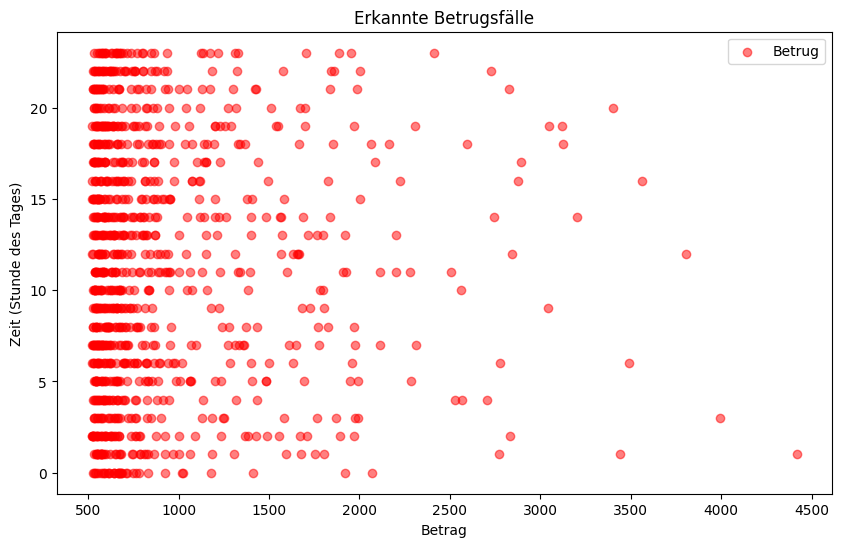

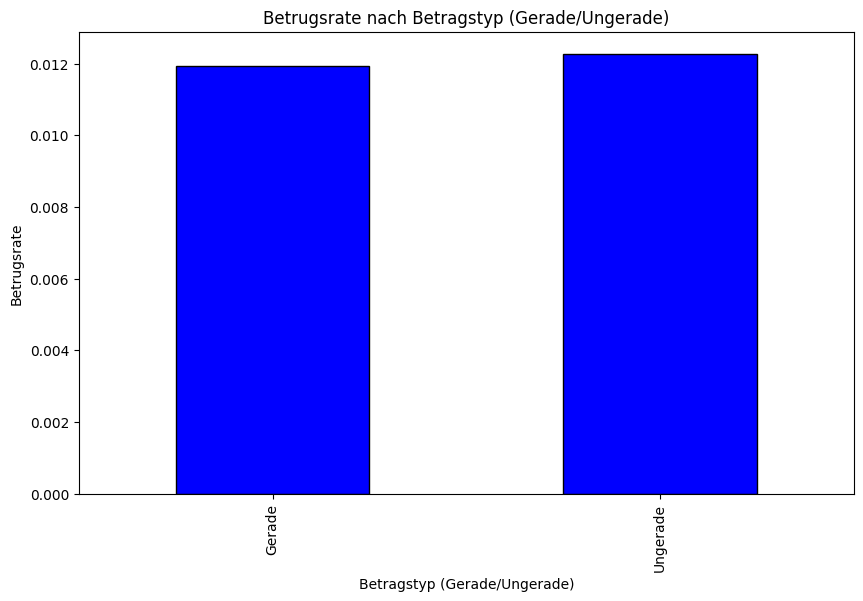

                     TransactionID      Amount   Time  CustomerID    CardType  \
Datetime                                                                        
2024-01-01 00:00:00              0   46.926809  19:36        1186        Visa   
2024-01-01 00:01:00              1  301.012143  08:07        1226        Amex   
2024-01-01 00:02:00              2  131.674569  19:33        1018  MasterCard   
2024-01-01 00:03:00              3  590.559969  13:09        1011  MasterCard   
2024-01-01 00:04:00              4   16.962487  11:35        1316    Discover   

                    TransactionType  Fraud AmountType  Anomaly  
Datetime                                                        
2024-01-01 00:00:00          Online      0     Gerade        1  
2024-01-01 00:01:00     Kartenleser      0   Ungerade        1  
2024-01-01 00:02:00     Kartenleser      0   Ungerade        1  
2024-01-01 00:03:00          Online      1     Gerade       -1  
2024-01-01 00:04:00     Kartenleser      0

In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.dates as mdates

# Generiere einen größeren Datensatz mit Kreditkartentransaktionen
def generate_dataset(num_samples=100000):
    np.random.seed(42)
    card_types = ['Visa', 'MasterCard', 'Amex', 'Discover']
    card_fraud_prob = {'Visa': 0.01, 'MasterCard': 0.015, 'Amex': 0.02, 'Discover': 0.005}
    transaction_types = ['Online', 'Kartenleser']

    data = {
        'TransactionID': np.arange(num_samples),
        'Amount': np.random.exponential(scale=100, size=num_samples),  # Transaktionsbeträge
        'Time': np.random.randint(0, 86400, num_samples),  # Zeitstempel in Sekunden des Tages
        'CustomerID': np.random.randint(1000, 2000, num_samples),  # Kunden-ID
        'CardType': np.random.choice(card_types, num_samples),  # Kreditkartenart
        'TransactionType': np.random.choice(transaction_types, num_samples)  # Transaktionstyp
    }

    data['Fraud'] = [np.random.binomial(1, card_fraud_prob[card_type]) for card_type in data['CardType']]

    # Einfügen von Betrugsmustern
    fraud_indices = np.where(np.array(data['Fraud']) == 1)[0]
    data['Amount'][fraud_indices] = data['Amount'][fraud_indices] * np.random.uniform(2, 10, size=len(fraud_indices))
    data['Time'][fraud_indices] = np.random.randint(0, 86400, size=len(fraud_indices))

    return pd.DataFrame(data)

# Funktion zur Umwandlung von Sekunden in Uhrzeit
def seconds_to_time(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    return f'{hours:02}:{minutes:02}'

# Datensatz generieren
df = generate_dataset()

# Umwandlung von Sekunden in Uhrzeit
df['Time'] = df['Time'].apply(seconds_to_time)

# Bestimmen, ob der Betrag gerade oder ungerade ist
df['AmountType'] = df['Amount'].apply(lambda x: 'Gerade' if int(x) % 2 == 0 else 'Ungerade')

# Datenbeschreibung
description = df.describe()

# Datenvorverarbeitung
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['Amount']])

# Isolation Forest Modell
model = IsolationForest(contamination=0.01, random_state=42)
df['Anomaly'] = model.fit_predict(scaled_data)

# Betrugsfälle extrahieren
fraud_cases = df[df['Anomaly'] == -1]

# Zeitserien-Analyse und Vorhersage
df['Datetime'] = pd.date_range(start='2024-01-01', periods=len(df), freq='T')
df.set_index('Datetime', inplace=True)

# Aggregation der Daten auf Tagesbasis nach Transaktionstyp
daily_amount_online = df[df['TransactionType'] == 'Online'].resample('D').sum()['Amount']
daily_amount_reader = df[df['TransactionType'] == 'Kartenleser'].resample('D').sum()['Amount']

# ARIMA Modell für die Vorhersage
model_online = ARIMA(daily_amount_online, order=(5, 1, 0))
fit_model_online = model_online.fit()

model_reader = ARIMA(daily_amount_reader, order=(5, 1, 0))
fit_model_reader = model_reader.fit()

# Vorhersage für die nächsten 30 Tage
forecast_online = fit_model_online.forecast(steps=30)
forecast_reader = fit_model_reader.forecast(steps=30)
forecast_dates = pd.date_range(daily_amount_online.index[-1] + pd.Timedelta(days=1), periods=30)

# Aggregation der Daten auf Tagesbasis nach Kartenart
daily_amount_by_card = df.groupby('CardType').resample('D').sum()['Amount']

# ARIMA Modelle für die Vorhersage nach Kartenart
fit_models_by_card = {}
forecasts_by_card = {}

for card_type in df['CardType'].unique():
    model = ARIMA(daily_amount_by_card[card_type], order=(5, 1, 0))
    fit_models_by_card[card_type] = model.fit()
    forecasts_by_card[card_type] = fit_models_by_card[card_type].forecast(steps=30)

# Analyse von geraden und ungeraden Beträgen
fraud_by_amount_type = df.groupby('AmountType')['Fraud'].mean()

# Visualisierungen

# 1. Scatterplot von Betrag vs. Zeit
plt.figure(figsize=(10, 6))
plt.scatter(df['Amount'], df.index, c=df['Anomaly'], cmap='coolwarm', alpha=0.6)
plt.xlabel('Betrag')
plt.ylabel('Transaktionsindex')
plt.title('Anomalieerkennung bei Kreditkartentransaktionen')
plt.colorbar(label='Anomalie-Score')
plt.xticks(rotation=45)
plt.show()

# 2. Histogramm der Transaktionsbeträge
plt.figure(figsize=(10, 6))
plt.hist(df['Amount'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Betrag')
plt.ylabel('Häufigkeit')
plt.title('Verteilung der Transaktionsbeträge')
plt.show()

# 3. Zeitverteilung der Transaktionen
plt.figure(figsize=(10, 6))
plt.hist(pd.to_datetime(df['Time'], format='%H:%M').dt.hour, bins=24, color='lightgreen', edgecolor='black')
plt.xlabel('Zeit (Stunde des Tages)')
plt.ylabel('Häufigkeit')
plt.title('Verteilung der Transaktionszeiten')
plt.show()

# 4. Betrügerische vs. Nicht-Betrügerische Transaktionen
fraud = df[df['Fraud'] == 1]
non_fraud = df[df['Fraud'] == 0]

plt.figure(figsize=(10, 6))
plt.scatter(non_fraud['Amount'], pd.to_datetime(non_fraud['Time'], format='%H:%M').dt.hour, c='blue', alpha=0.5, label='Nicht-Betrug')
plt.scatter(fraud['Amount'], pd.to_datetime(fraud['Time'], format='%H:%M').dt.hour, c='red', alpha=0.5, label='Betrug')
plt.xlabel('Betrag')
plt.ylabel('Zeit (Stunde des Tages)')
plt.title('Betrug vs. Nicht-Betrug Transaktionen')
plt.legend()
plt.show()

# 5. Trend und Vorhersage der täglichen Transaktionsbeträge nach Transaktionstyp
plt.figure(figsize=(14, 8))
plt.plot(daily_amount_online.index, daily_amount_online, label='Tägliche Transaktionsbeträge - Online')
plt.plot(forecast_dates, forecast_online, label='Vorhergesagte Beträge - Online', linestyle='--')
plt.plot(daily_amount_reader.index, daily_amount_reader, label='Tägliche Transaktionsbeträge - Kartenleser')
plt.plot(forecast_dates, forecast_reader, label='Vorhergesagte Beträge - Kartenleser', linestyle='--')
plt.xlabel('Datum')
plt.ylabel('Gesamtbetrag')
plt.title('Trend und Vorhersage der täglichen Transaktionsbeträge nach Transaktionstyp')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# 6. Trend und Vorhersage der täglichen Transaktionsbeträge nach Kartenart
plt.figure(figsize=(14, 8))
for card_type in df['CardType'].unique():
    plt.plot(daily_amount_by_card[card_type].index, daily_amount_by_card[card_type], label=f'Tägliche Transaktionsbeträge - {card_type}')
    plt.plot(forecast_dates, forecasts_by_card[card_type], linestyle='--', label=f'Vorhergesagte Beträge - {card_type}')
plt.xlabel('Datum')
plt.ylabel('Gesamtbetrag')
plt.title('Trend und Vorhersage der täglichen Transaktionsbeträge nach Kartenart')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# 7. Betrugsraten nach Kreditkartenart
fraud_by_card = df.groupby('CardType')['Fraud'].mean()

plt.figure(figsize=(10, 6))
fraud_by_card.plot(kind='bar', color='orange', edgecolor='black')
plt.xlabel('Kartenart')
plt.ylabel('Betrugsrate')
plt.title('Betrugsrate nach Kartenart')
plt.show()

# 8. Betrugsraten nach Transaktionstyp
fraud_by_transaction = df.groupby('TransactionType')['Fraud'].mean()

plt.figure(figsize=(10, 6))
fraud_by_transaction.plot(kind='bar', color='purple', edgecolor='black')
plt.xlabel('Transaktionstyp')
plt.ylabel('Betrugsrate')
plt.title('Betrugsrate nach Transaktionstyp')
plt.show()

# 9. Betrugsfälle als Tabelle und Visualisierung
print("Betrugsfälle:")
print(fraud_cases)

plt.figure(figsize=(10, 6))
plt.scatter(fraud_cases['Amount'], pd.to_datetime(fraud_cases['Time'], format='%H:%M').dt.hour, c='red', alpha=0.5, label='Betrug')
plt.xlabel('Betrag')
plt.ylabel('Zeit (Stunde des Tages)')
plt.title('Erkannte Betrugsfälle')
plt.legend()
plt.show()

# 10. Betrugsraten nach geraden und ungeraden Beträgen
plt.figure(figsize=(10, 6))
fraud_by_amount_type.plot(kind='bar', color='blue', edgecolor='black')
plt.xlabel('Betragstyp (Gerade/Ungerade)')
plt.ylabel('Betrugsrate')
plt.title('Betrugsrate nach Betragstyp (Gerade/Ungerade)')
plt.show()

# Ausgabe der ersten Zeilen des Datensatzes und der Beschreibung
print(df.head())
print(description)
